# Prediction house prices and time to sell for houses on Funda

In this notebook we show how one can predict the prices of houses on funda, aswell as the time it takes for these houses to sell

In [13]:
#Installing packages
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import PredefinedSplit, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from plotnine import *
import os
import datetime
import pickle
import json

In [14]:
#Importing tools to display outputs properly
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # to make jupyter print all outputs, not just the last one
from IPython.core.display import HTML # to pretty print pandas df and be able to copy them over (e.g. to ppt slides)

In [15]:
# Defining constants for SVC models
USE_STORED_SVC_HYPERTUNED_MODELS = True
USE_STORED_SVC_SKLEARNED_HYPERTUNED_MODELS = True
USE_STORED_NN_HYPERTUNED_MODELS = True

In [16]:
# Reading funda data frame as feather
#df = pd.read_csv('funda_and_topic.csv') # Reading dataframe as csv
#df.to_feather('funda_and_topic.csv') # Converting dataframe to feather
df = pd.read_feather('funda_and_topic.csv') 

In [17]:
#printing df
df.head()

,id,house_description_lenght,main_topic,house_description,living_area_surface,property_surface,construction_year,garden,type_house,energy_label,...,sell_time,plaats,postcode,ask_price,number_room,bedrooms,sell_time_cal,construction_year_1,asking_price,type_house1
0,0,1952,Topic1,"Een heerlijk, lichte middenwoning gelegen in...",115,166,1962,Tuin,"Eengezinswoning, tussenwoning",D,...,4 weken,Heiloo,1851SK,375.000,6,5,28,1962,375000,Eengezinswoning
1,1,3527,Topic5,Instapklare en ruime twee-onder-een-kapwoning...,130,243,1992,Tuin,"Eengezinswoning, 2-onder-1-kapwoning",A,...,12 dagen,Vlijmen,5251SG,425.000,5,4,12,1992,425000,Eengezinswoning
2,2,2761,Topic9,Mooie en ruime helft van een dubbel woonhui...,124,245,1981,Tuin,"Eengezinswoning, 2-onder-1-kapwoning",C,...,3 maanden,Dinxperlo,7091TB,299.000,5,4,104,1981,299000,Eengezinswoning
3,3,3273,Topic1,Geheel opgeknapte hoekwoning met dakopbouw e...,92,257,1961,Tuin,"Eengezinswoning, hoekwoning",D,...,2 weken,Hellevoetsluis,3222CA,295.000,5,4,18,1961,295000,Eengezinswoning
4,4,5966,Topic5,Deze ruime en goed onderhouden eindwoning m...,126,131,1983,Tuin,"Eengezinswoning, eindwoning",A,...,3 weken,Rotterdam,3068GN,345.000,5,4,24,1983,345000,Eengezinswoning


In [ ]:
#Renaming unnamed first columns to ID
df.rename(columns={'Unnamed: 0': 'id'}, inplace=True)

In [ ]:
#Checking of datatypes match prefered datatypes
df.dtypes

id                      int64
house_description      object
living_area_surface     int64
property_surface        int64
construction_year      object
garden                 object
type_house             object
energy_label           object
number_bathrooms       object
aantalfotos             int64
publication_date       object
date_of_signiture      object
sell_time              object
plaats                 object
postcode               object
ask_price              object
number_room             int64
bedrooms                int64
sell_time_cal           int64
construction_year_1     int64
asking_price            int64
type_house1            object
dtype: object

In [8]:
df.head()
df.tail()

,id,house_description,living_area_surface,property_surface,construction_year,garden,type_house,energy_label,number_bathrooms,aantalfotos,...,sell_time,plaats,postcode,ask_price,number_room,bedrooms,sell_time_cal,construction_year_1,asking_price,type_house1
0,0,"Een heerlijk, lichte middenwoning gelegen in...",115,166,1962,Tuin,"Eengezinswoning, tussenwoning",D,1 badkamer en 1 apart toilet,61,...,4 weken,Heiloo,1851SK,375.000,6,5,28,1962,375000,Eengezinswoning
1,1,Instapklare en ruime twee-onder-een-kapwoning...,130,243,1992,Tuin,"Eengezinswoning, 2-onder-1-kapwoning",A,1 badkamer en 1 apart toilet,46,...,12 dagen,Vlijmen,5251SG,425.000,5,4,12,1992,425000,Eengezinswoning
2,2,Mooie en ruime helft van een dubbel woonhui...,124,245,1981,Tuin,"Eengezinswoning, 2-onder-1-kapwoning",C,1 badkamer en 1 apart toilet,43,...,3 maanden,Dinxperlo,7091TB,299.000,5,4,104,1981,299000,Eengezinswoning
3,3,Geheel opgeknapte hoekwoning met dakopbouw e...,92,257,1961,Tuin,"Eengezinswoning, hoekwoning",D,1 badkamer en 1 apart toilet,35,...,2 weken,Hellevoetsluis,3222CA,295.000,5,4,18,1961,295000,Eengezinswoning
4,4,Deze ruime en goed onderhouden eindwoning m...,126,131,1983,Tuin,"Eengezinswoning, eindwoning",A,1 badkamer en 1 apart toilet,29,...,3 weken,Rotterdam,3068GN,345.000,5,4,24,1983,345000,Eengezinswoning


,id,house_description,living_area_surface,property_surface,construction_year,garden,type_house,energy_label,number_bathrooms,aantalfotos,...,sell_time,plaats,postcode,ask_price,number_room,bedrooms,sell_time_cal,construction_year_1,asking_price,type_house1
169712,174955,Aan de burgemeester Vogelaarstraat in Kruini...,88,266,1956,Tuin,"Eengezinswoning, vrijstaande woning",F,1 badkamer en 1 apart toilet,45,...,6 weken,Kruiningen,4416BP,265.000,5,3,43,1956,265000,Eengezinswoning
169713,174956,KEURIG ONDERHOUDEN TUSSENWONING MET ZONNIG G...,103,93,1984,Tuin,"Eengezinswoning, tussenwoning",B,1 badkamer en 1 apart toilet,30,...,7 weken,Delft,2622GH,329.500,4,3,52,1984,329500,Eengezinswoning
169714,174957,"Op een hele fijne plek, centraal in Maaslan...",109,156,1968,Achtertuin,"Eengezinswoning, tussenwoning",C,1 badkamer en 1 apart toilet,49,...,2 weken,Maasland,3155VD,367.000,5,4,20,1968,367000,Eengezinswoning
169715,174958,"** Englisch text below ** , ,U bent van ha...",234,455,1960,Tuin,"Villa, vrijstaande woning (drive-in woning)",F,2 badkamers en 2 aparte toiletten,53,...,4 weken,Diemen,1111EW,1.000.000,5,4,31,1960,1000000,Villa
169716,174959,Vanwege de grote belangstelling voor deze w...,118,200,1981,Tuin,"Eengezinswoning, hoekwoning",C,1 badkamer en 1 apart toilet,55,...,2 weken,Hellevoetsluis,3224PN,bij,5,4,20,1981,0,Eengezinswoning


# Creating the train, test, and validation splits

- **We split the dataset into train, validation, and test**
- The test set will be set aside, it will be used at the end to evaluate the model by measuring it's performance. 
- The train set will be used along side the validation set to fit the model
- We split the data using a 80/20 split for training and validation, while 20% of the data is seperated for the testing at the end

In [9]:
#Class to seperate the dataframe into Train/Test/Validation
class TrainTestSplitter(object):
    '''Class to perform the split of the data into train, test, and validation.
    '''
    def __init__(self, train_frac=0.8, validation_frac=0.2, seed=1234):
        self.train_frac = train_frac
        self.validation_frac = validation_frac
        self.seed = seed 
    #Defining a statistics calculation to analyse if sets have been split evenly
    def calculate_statistics(self):
        statistics = {}
        for i in ['train_set', 'test_set', 'validation_set']:
            split_stats = {}
            sell_time_cal_count = (getattr(self, i).groupby('sell_time_cal').size().reset_index())
            split_stats['N_sell_time_cal'] = (sell_time_cal_count.loc[lambda x: x.sell_time_cal ==1, 0].iloc[0])
            split_stats['percentage_total_sell_time_cal'] = split_stats['N_sell_time_cal']/self.total_n_sell_time_cal * 100
            split_stats['N_not_sell_time_cal'] = sell_time_cal_count.loc[lambda x: x.sell_time_cal == 0, 0].iloc[0]
            split_stats['percentage_total_not_sell_time_cal'] = split_stats['N_not_sell_time_cal']/self.total_n_not_sell_time_cal * 100
            statistics[i] = split_stats
        self.split_statistics = statistics
    #actual splitting of the data
    def split_train_test(self, df):
        print("Generating the train/validation/test splits...")
        self.total_n_sell_time_cal = df.loc[lambda x: x.sell_time_cal == 1].shape[0]
        self.total_n_not_sell_time_cal = df.loc[lambda x: x.sell_time_cal == 0].shape[0]
        self.train_set = df.sample(frac=self.train_frac, random_state=self.seed)
        self.test_set = df.loc[lambda x: ~x.id.isin(self.train_set.id)].reset_index(drop=True)
        self.validation_set = self.train_set.sample(frac=self.validation_frac).reset_index(drop=True)
        self.train_set = self.train_set.loc[lambda x: ~x.id.isin(self.validation_set.id)].reset_index(drop=True)
        print("calculating the statistics...")
        self.calculate_statistics()
        print("split completed")

In [10]:
# create a fitting_splits object that will hold the train, validation, and test data
fitting_splits = TrainTestSplitter()

In [11]:
#Intializing the traintestsplitter
fitting_splits.split_train_test(df)

Generating the train/validation/test splits...
calculating the statistics...
split completed


In [12]:
#Identifying shape of the test set matrix
fitting_splits.test_set.shape

(33943, 22)

In [13]:
#Identifying the statistics of the splitted matrixes
fitting_splits.split_statistics

{'train_set': {'N_sell_time_cal': 229,
  'percentage_total_sell_time_cal': 64.14565826330532,
  'N_not_sell_time_cal': 671,
  'percentage_total_not_sell_time_cal': 61.78637200736649},
 'test_set': {'N_sell_time_cal': 70,
  'percentage_total_sell_time_cal': 19.607843137254903,
  'N_not_sell_time_cal': 240,
  'percentage_total_not_sell_time_cal': 22.099447513812155},
 'validation_set': {'N_sell_time_cal': 58,
  'percentage_total_sell_time_cal': 16.246498599439775,
  'N_not_sell_time_cal': 175,
  'percentage_total_not_sell_time_cal': 16.114180478821364}}

# Dummification and scaling

Before fitting a model to our data, we need to deal with two data transformations that are **essential** to be able to obtain a performant model. These are **dummification** or **one-hot-encoding** and **scaling**.

### Dummification
- **Dummification** is used to transform categorical variables into numerical variables, since most machine learning models can only deal with numerical variables. 
- In dummification, we transform a categorical variable with N values into C_0, ..., C_N columns that take only 0 or 1 values. A row then has exactly one of these columns with 1, and the others with 0, namely, the column corresponding to the original value of the categorical variable for that row.
We have used the sklearn one hot encoder to encode the garden, energy label, type_house1 variables. 

### Scaling
- **feature scaling** refers to the application of a transformation to the numerical variables in the dataset which normalizes the range of the numerical variables, ensuring that these ranges are the same
- this is performed because often numerical variables can have wildly different ranges.

In [14]:
# install the scikit-learn package if it hasn't been done yet
#pip install -U scikit-learn


In [15]:
# 1. fit a one hot encoder transformer to the TRAIN SET. 

one_hot_encoder = OneHotEncoder() 
one_hot_encoder.fit(fitting_splits.train_set[['garden', 'energy_label', 'type_house1', ]]) # we fit the encoder only on columns that need the transformation.

OneHotEncoder()

In [16]:
fitting_splits.train_set

,id,house_description,living_area_surface,property_surface,construction_year,garden,type_house,energy_label,number_bathrooms,aantalfotos,...,sell_time,plaats,postcode,ask_price,number_room,bedrooms,sell_time_cal,construction_year_1,asking_price,type_house1
0,126393,!!! Door de grote belangstelling kunnen wij...,64,2,1960-1970,Balkon/dakterras,Portiekflat (open portiek),C,1 badkamer,35,...,3 weken,Sneek,8608BP,147.500,4,2,23,1960,147500,Portiekflat
1,104450,Of u nou al een jong gezin heeft of hier i...,93,129,1958,Tuin,"Eengezinswoning, tussenwoning",C,1 badkamer en 1 apart toilet,40,...,2 weken,Hillegom,2181TS,325.000,5,4,19,1958,325000,Eengezinswoning
2,142727,Je zet je fiets in de berging en via de ge...,80,2,2021,Tuin,Bovenwoning (appartement),A,1 woonlaag,4,...,6½ maand,Moordrecht,2841ME,350.000,3,2,197,2021,350000,Bovenwoning
3,172220,Op uitstekende locatie in gewilde wijk Sacr...,127,120,1934,Tuin,"Eengezinswoning, tussenwoning",F,1 badkamer en 1 apart toilet,28,...,14 dagen,Tilburg,5018CH,375.000,4,3,14,1934,375000,Eengezinswoning
4,80900,ZEER RUIM HOEKAPPARTEMENT (118m2!) MIDDEN IN...,118,3,1978,Balkon/dakterras,Portiekflat (appartement),B,1 badkamer en 1 apart toilet,27,...,3 weken,Rotterdam,3083BV,275.000,4,3,21,1978,275000,Portiekflat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108614,139874,Op een perceel van 477 m2 is deze vrijstaa...,105,477,1960,Tuin,"Eengezinswoning, vrijstaande woning",E,1 apart toilet,37,...,2 weken,De Mortel,5425VW,285.000,6,4,18,1960,285000,Eengezinswoning
108615,74211,"WONEN IN RINGERS , ,HET MONUMENTALE VISITEK...",88,1,2021,Geen tuin,Portiekflat (appartement),A,1 woonlaag,8,...,5½ maand,Alkmaar,1823CJ,325.000,2,1,175,2021,325000,Portiekflat
108616,77311,Let op: Dit appartement gelegen nabij het c...,54,1,1993,Balkon/dakterras,Portiekflat (appartement),B,1 badkamer en 1 apart toilet,21,...,2 weken,Almere,1325GZ,217.500,2,1,19,1993,217500,Portiekflat
108617,38995,"De bieding is gesloten. ,De woning is verko...",98,2,1970,Geen tuin,Galerijflat (appartement),A,1 apart toilet,30,...,2 weken,Tilburg,5011SP,202.500,3,2,15,1970,202500,Galerijflat


In [17]:
# Identifying if encoding was succesfull
one_hot_encoder.categories_ # after we fit the encoder, the instance learns which values are present in each data column.
encoded_names = one_hot_encoder.get_feature_names() # obtain new feature names
encoded_names
encoded_categories = one_hot_encoder.transform(fitting_splits.train_set[['garden', 'energy_label', 'type_house1']]).toarray() #fits the new labels into an array
df_encoded = pd.DataFrame(encoded_categories)
df_encoded.columns = encoded_names
df_encoded

[array(['Achtertuin', 'Balkon/dakterras', 'Geen tuin', 'Patio/atrium',
        'Tuin', 'Voortuin', 'Voorzieningen', 'Zijtuin', 'Zonneterras'],
       dtype=object),
 array(['A', 'A+', 'A++', 'A+++', 'A++++', 'A+++++', 'B', 'C', 'D', 'E',
        'F', 'G'], dtype=object),
 array(['Beneden', 'Benedenwoning', 'Bovenwoning', 'Bungalow', 'Dubbel',
        'Eengezinswoning', 'Galerijflat', 'Grachtenpand', 'Herenhuis',
        'Landgoed', 'Landhuis', 'Maisonnette', 'Penthouse', 'Portiekflat',
        'Portiekwoning', 'Studentenkamer', 'Tussenverdieping', 'Villa',
        'Woonboerderij', 'Woonboot', 'Woonwagen'], dtype=object)]

C:\Users\Eigenaar\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


array(['x0_Achtertuin', 'x0_Balkon/dakterras', 'x0_Geen tuin',
       'x0_Patio/atrium', 'x0_Tuin', 'x0_Voortuin', 'x0_Voorzieningen',
       'x0_Zijtuin', 'x0_Zonneterras', 'x1_A', 'x1_A+', 'x1_A++',
       'x1_A+++', 'x1_A++++', 'x1_A+++++', 'x1_B', 'x1_C', 'x1_D', 'x1_E',
       'x1_F', 'x1_G', 'x2_Beneden', 'x2_Benedenwoning', 'x2_Bovenwoning',
       'x2_Bungalow', 'x2_Dubbel', 'x2_Eengezinswoning', 'x2_Galerijflat',
       'x2_Grachtenpand', 'x2_Herenhuis', 'x2_Landgoed', 'x2_Landhuis',
       'x2_Maisonnette', 'x2_Penthouse', 'x2_Portiekflat',
       'x2_Portiekwoning', 'x2_Studentenkamer', 'x2_Tussenverdieping',
       'x2_Villa', 'x2_Woonboerderij', 'x2_Woonboot', 'x2_Woonwagen'],
      dtype=object)

,x0_Achtertuin,x0_Balkon/dakterras,x0_Geen tuin,x0_Patio/atrium,x0_Tuin,x0_Voortuin,x0_Voorzieningen,x0_Zijtuin,x0_Zonneterras,x1_A,...,x2_Maisonnette,x2_Penthouse,x2_Portiekflat,x2_Portiekwoning,x2_Studentenkamer,x2_Tussenverdieping,x2_Villa,x2_Woonboerderij,x2_Woonboot,x2_Woonwagen
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108614,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
108615,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
108616,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
108617,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
#Checking if df types are still consistent.
df.dtypes

id                      int64
house_description      object
living_area_surface     int64
property_surface        int64
construction_year      object
garden                 object
type_house             object
energy_label           object
number_bathrooms       object
aantalfotos             int64
publication_date       object
date_of_signiture      object
sell_time              object
plaats                 object
postcode               object
ask_price              object
number_room             int64
bedrooms                int64
sell_time_cal           int64
construction_year_1     int64
asking_price            int64
type_house1            object
dtype: object

In [19]:
# after we have generated the dummy columns we have dropped the original columns from the training data, and replaced them with the dummy columns
train_set = fitting_splits.train_set.drop(['house_description', 'construction_year', 'garden', 'type_house', 'energy_label', 'number_bathrooms', 'publication_date', 'date_of_signiture', 'sell_time', 'plaats', 'postcode', 'ask_price', 'type_house1'], axis=1)
train_set = pd.concat([train_set, df_encoded], axis=1)
train_set

,id,living_area_surface,property_surface,aantalfotos,number_room,bedrooms,sell_time_cal,construction_year_1,asking_price,x0_Achtertuin,...,x2_Maisonnette,x2_Penthouse,x2_Portiekflat,x2_Portiekwoning,x2_Studentenkamer,x2_Tussenverdieping,x2_Villa,x2_Woonboerderij,x2_Woonboot,x2_Woonwagen
0,126393,64,2,35,4,2,23,1960,147500,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,104450,93,129,40,5,4,19,1958,325000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,142727,80,2,4,3,2,197,2021,350000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,172220,127,120,28,4,3,14,1934,375000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,80900,118,3,27,4,3,21,1978,275000,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108614,139874,105,477,37,6,4,18,1960,285000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
108615,74211,88,1,8,2,1,175,2021,325000,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
108616,77311,54,1,21,2,1,19,1993,217500,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
108617,38995,98,2,30,3,2,15,1970,202500,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
# now we fit the StandardScaler, in order to standardize all the features
standard_scaler = StandardScaler()
standard_scaler.fit(train_set)
# the above standard scaler, when apply to a dataset with the same columns as the train set, will scale all the numerical features and return a numpy array
standard_scaler.transform(train_set)

StandardScaler()

array([[ 0.76643633, -1.09214131, -0.8970935 , ..., -0.1072417 ,
        -0.01094069, -0.00429107],
       [ 0.33096574, -0.52810612, -0.21781571, ..., -0.1072417 ,
        -0.01094069, -0.00429107],
       [ 1.09059332, -0.78094948, -0.8970935 , ..., -0.1072417 ,
        -0.01094069, -0.00429107],
       ...,
       [-0.20762226, -1.2866362 , -0.90244214, ..., -0.1072417 ,
        -0.01094069, -0.00429107],
       [-0.96802382, -0.43085868, -0.8970935 , ..., -0.1072417 ,
        -0.01094069, -0.00429107],
       [ 0.40697414, -0.93654539, -0.8970935 , ..., -0.1072417 ,
        -0.01094069, -0.00429107]])

Once we have a one hot encoder and a standard scaler fitted on the training data, it is handy to combine all the transformations needed to prepare a dataset with the same schema as the training dataset into a class. This is so that we can apply it to training/validation/test, and any new dataset with the same columns that we might get in the future.

In [21]:
#Defining a class that prepares the data for future iterations in the validation and training set.
class DataPreparer(object):
    def __init__(self, one_hot_encoder, standard_scaler):
        self.one_hot_encoder = one_hot_encoder
        self.standard_scaler = standard_scaler

    def dummify(self, df):
        vars_to_encode = ['garden', 'energy_label', 'type_house1']
        df_to_encode = df[vars_to_encode]
        df_encoded = self.one_hot_encoder.transform(df_to_encode).toarray()
        df_encoded = pd.DataFrame(df_encoded)
        df_encoded.columns = self.one_hot_encoder.get_feature_names()
        # add the encoded columns and drop the original columns
        df = df.drop(['house_description', 'construction_year', 'garden', 'type_house', 'energy_label', 'number_bathrooms', 'publication_date', 'date_of_signiture', 'sell_time', 'plaats', 'postcode', 'ask_price', 'type_house1'], axis=1)
        df = pd.concat([df, df_encoded], axis=1)
        return df

    def scale(self, df):
        cols = df.columns
        df = self.standard_scaler.transform(df)
        df = pd.DataFrame(df)
        df.columns = cols
        return df

    def prepare_data(self, df):
        df = df.reset_index(drop=True)
        # first dummify the data
        df = self.dummify(df)
        # then scale it
        df = self.scale(df)
        return df

In [22]:
df.columns

Index(['id', 'house_description', 'living_area_surface', 'property_surface',
       'construction_year', 'garden', 'type_house', 'energy_label',
       'number_bathrooms', 'aantalfotos', 'publication_date',
       'date_of_signiture', 'sell_time', 'plaats', 'postcode', 'ask_price',
       'number_room', 'bedrooms', 'sell_time_cal', 'construction_year_1',
       'asking_price', 'type_house1'],
      dtype='object')

In [23]:
#Checking if all values of the train and validation set have been changed to numbers
data_preparer = DataPreparer(one_hot_encoder, standard_scaler)
data_preparer.prepare_data(fitting_splits.train_set).head()
data_preparer.prepare_data(fitting_splits.validation_set).head()

C:\Users\Eigenaar\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


,id,living_area_surface,property_surface,aantalfotos,number_room,bedrooms,sell_time_cal,construction_year_1,asking_price,x0_Achtertuin,...,x2_Maisonnette,x2_Penthouse,x2_Portiekflat,x2_Portiekwoning,x2_Studentenkamer,x2_Tussenverdieping,x2_Villa,x2_Woonboerderij,x2_Woonboot,x2_Woonwagen
0,0.766436,-1.092141,-0.897093,-0.047499,-0.429502,-1.047610,-0.202071,-0.289098,-1.038269,-0.236402,...,-0.148739,-0.076745,3.157611,-0.093131,-0.006069,-0.078367,-0.170661,-0.107242,-0.010941,-0.004291
1,0.330966,-0.528106,-0.217816,0.338084,0.196331,0.623406,-0.243053,-0.343203,-0.309837,-0.236402,...,-0.148739,-0.076745,-0.316695,-0.093131,-0.006069,-0.078367,-0.170661,-0.107242,-0.010941,-0.004291
2,1.090593,-0.780949,-0.897093,-2.438112,-1.055334,-1.047610,1.580651,1.361090,-0.207241,-0.236402,...,-0.148739,-0.076745,-0.316695,-0.093131,-0.006069,-0.078367,-0.170661,-0.107242,-0.010941,-0.004291
3,1.675898,0.133177,-0.265954,-0.587315,-0.429502,-0.212102,-0.294280,-0.992457,-0.104645,-0.236402,...,-0.148739,-0.076745,-0.316695,-0.093131,-0.006069,-0.078367,-0.170661,-0.107242,-0.010941,-0.004291
4,-0.136397,-0.041869,-0.891745,-0.664431,-0.429502,-0.212102,-0.222562,0.197843,-0.515029,-0.236402,...,-0.148739,-0.076745,3.157611,-0.093131,-0.006069,-0.078367,-0.170661,-0.107242,-0.010941,-0.004291


C:\Users\Eigenaar\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


,id,living_area_surface,property_surface,aantalfotos,number_room,bedrooms,sell_time_cal,construction_year_1,asking_price,x0_Achtertuin,...,x2_Maisonnette,x2_Penthouse,x2_Portiekflat,x2_Portiekwoning,x2_Studentenkamer,x2_Tussenverdieping,x2_Villa,x2_Woonboerderij,x2_Woonboot,x2_Woonwagen
0,1.711124,-0.683702,-0.897093,-0.587315,-1.055334,-1.047610,-0.253298,0.116686,-0.515029,4.230076,...,6.723183,-0.076745,-0.316695,-0.093131,-0.006069,-0.078367,-0.170661,-0.107242,-0.010941,-0.004291
1,-1.534693,1.689136,-0.105494,-0.741548,2.699661,3.129931,0.023331,-0.992457,6.502542,-0.236402,...,-0.148739,-0.076745,-0.316695,-0.093131,-0.006069,-0.078367,-0.170661,-0.107242,-0.010941,-0.004291
2,0.679017,-0.936545,-0.897093,-0.972897,-1.055334,-1.047610,-0.294280,-0.234994,-0.781779,-0.236402,...,-0.148739,-0.076745,-0.316695,-0.093131,-0.006069,-0.078367,-0.170661,-0.107242,-0.010941,-0.004291
3,-0.484467,-0.761500,0.760986,1.263483,0.196331,0.623406,-0.027897,-0.234994,-0.966452,-0.236402,...,-0.148739,-0.076745,-0.316695,-0.093131,-0.006069,-0.078367,-0.170661,-0.107242,-0.010941,-0.004291
4,0.873364,-0.022419,-0.886396,-2.283879,0.196331,0.623406,-0.079124,1.361090,-0.414485,-0.236402,...,-0.148739,-0.076745,-0.316695,-0.093131,-0.006069,-0.078367,-0.170661,-0.107242,-0.010941,-0.004291


# Modeling with SVC

This section consists of four parts.
1. First, we are going to train a default SVC model on the train set, and use it to predict on the test set. 
2. We are going to evaluate the predictions that the above model generates on the test set. 
3. If this is succesful, we are going to:
    - perform a train-validation grid-search in the hyperparameter space of the SVC model (**hyperparameter tuning**)
    - choose the best set of hyperparameters among those explored
    - train a SVC model with the found hyperparameters on train + validation, and predict on test 
4. Finally, we are going to evaluate the predictions of the resulting model at point 3

## Simple train/test model

In [24]:
from sklearn.ensemble import RandomForestRegressor

# get the transformed train set
train_set_transformed = data_preparer.prepare_data(fitting_splits.train_set)
X_train = train_set_transformed.drop(['sell_time_cal', 'id'], axis=1) # need to drop the target! otherwise data leakage
X_train = X_train.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)
y_train = fitting_splits.train_set['sell_time_cal'] # take it from the original untransformed dataset
# create the model instance
regressor = RandomForestRegressor(n_estimators=20, random_state=0)
# fit the model instance on X_train
RF = regressor.fit(X=X_train, y=y_train.values.ravel())

C:\Users\Eigenaar\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


In [25]:
# use the fitted simple_SVC model to predict on the test dataset
X_test = data_preparer.prepare_data(fitting_splits.test_set).drop(['sell_time_cal', 'id'], axis=1)
X_test = X_test.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)
y_test = fitting_splits.test_set['sell_time_cal']

y_hat_test = regressor.predict(X_test)
# Obtain vector of predicted class
pd.Series(y_hat_test)

C:\Users\Eigenaar\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


0          24.70
1          26.55
2          32.10
3          56.40
4          43.45
          ...   
33938      40.20
33939     134.55
33940    1329.15
33941      35.15
33942      26.30
Length: 33943, dtype: float64

In [26]:
#Obtain statistics on the prediction set.
pd.Series(y_hat_test).describe()
fitting_splits.test_set['sell_time_cal'].describe()

count    33943.000000
mean        46.329258
std         58.203996
min          1.000000
25%         23.450000
50%         29.900000
75%         44.700000
max       2508.600000
dtype: float64

count    33943.000000
mean        42.255104
std         87.509869
min          0.000000
25%         16.000000
50%         22.000000
75%         33.000000
max       3648.000000
Name: sell_time_cal, dtype: float64

In [27]:
#In order to identify the accuracy of the model we perform a few tests
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_hat_test))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_hat_test))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_hat_test)))
print('R2 Value:',metrics.r2_score(y_test, RF.predict(X_test)))

Mean Absolute Error: 31.517249173091866
Mean Squared Error: 7267.399291653418
Root Mean Squared Error: 85.24904276092147
R2 Value: 0.050974784594965517


Our R2 value is relatively low, in general we would hope to achieve a R2 score of atleast 0.4 so we need to look further into improving our model

In [28]:
import warnings
warnings.filterwarnings('ignore')

# Add the predictions of time to sell to the model.
predictions = regressor.predict(X_test)

result = X_test
result['sell_time_cal'] = y_test
result['prediction'] = predictions.tolist()
result.head()

,living_area_surface,property_surface,aantalfotos,number_room,bedrooms,construction_year_1,asking_price,x0_Achtertuin,x0_Balkon/dakterras,x0_Geen tuin,...,x2_Portiekflat,x2_Portiekwoning,x2_Studentenkamer,x2_Tussenverdieping,x2_Villa,x2_Woonboerderij,x2_Woonboot,x2_Woonwagen,sell_time_cal,prediction
0,0.191525,0.391930,0.800784,0.196331,0.623406,0.576575,0.100547,-0.236402,-0.412857,-0.393613,...,-0.316695,-0.093131,-0.006069,-0.078367,-0.170661,-0.107242,-0.010941,-0.004291,12,24.70
1,-0.547556,0.466811,-0.047499,0.196331,0.623406,-0.262046,-0.432952,-0.236402,-0.412857,-0.393613,...,-0.316695,-0.093131,-0.006069,-0.078367,-0.170661,-0.107242,-0.010941,-0.004291,18,26.55
2,0.230424,-0.651056,0.569434,0.822163,0.623406,0.982359,-0.207241,-0.236402,2.422147,-0.393613,...,-0.316695,-0.093131,-0.006069,-0.078367,-0.170661,-0.107242,-0.010941,-0.004291,19,32.10
3,1.494641,-0.014567,1.494833,3.951326,3.129931,-1.533503,2.029353,-0.236402,-0.412857,-0.393613,...,-0.316695,-0.093131,-0.006069,-0.078367,-0.170661,-0.107242,-0.010941,-0.004291,17,56.40
4,-0.489207,0.284957,0.106735,0.196331,0.623406,0.333104,0.059509,-0.236402,-0.412857,-0.393613,...,-0.316695,-0.093131,-0.006069,-0.078367,-0.170661,-0.107242,-0.010941,-0.004291,14,43.45


Text(0.5, 0, 'number_room')

Text(0, 0.5, 'sell_time_cal')

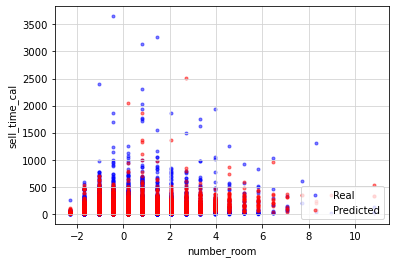

In [29]:
# Import library for visualization
import matplotlib.pyplot as plt

# Define the x axis
x_axis = X_test['number_room']

# Build scatterplot to see distribution of data
plt.scatter(x_axis, y_test, c = 'b', alpha = 0.5, marker = '.', label = 'Real')
plt.scatter(x_axis, predictions, c = 'r', alpha = 0.5, marker = '.', label = 'Predicted')
plt.xlabel('number_room')
plt.ylabel('sell_time_cal')
plt.grid(color = '#D3D3D3', linestyle = 'solid')
plt.legend(loc = 'lower right')
plt.show()

The model seems to predcit relatively safely when matched with the number of rooms of a house.  
This can be explained due to the high volume of low sell time compared to longer sell time (high demand)

Text(0.5, 0, 'living_area_surfacee')

Text(0, 0.5, 'sell_time_cal')

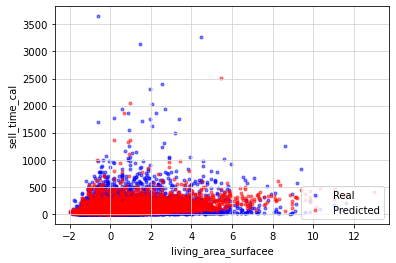

In [30]:
# Define x axis
x_axis = X_test['living_area_surface']

# Build scatterplot
plt.scatter(x_axis, y_test, c = 'b', alpha = 0.5, marker = '.', label = 'Real')
plt.scatter(x_axis, predictions, c = 'r', alpha = 0.5, marker = '.', label = 'Predicted')
plt.xlabel('living_area_surfacee')
plt.ylabel('sell_time_cal')
plt.grid(color = '#D3D3D3', linestyle = 'solid')
plt.legend(loc = 'lower right')
plt.show()

Similar to the numer of rooms, the living area surface seems to be predicted rather safely. However, it seems to push for a steady growing line in terms of sell time

In [31]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
r2 = r2_score(y_test.values.ravel(), predictions)
print('R-squared scores:', round(r2, 2))

R-squared scores: 0.05


In [32]:
#creating validation data
X_validation = data_preparer.prepare_data(fitting_splits.validation_set).drop(['sell_time_cal', 'id'], axis=1)
y_validation = fitting_splits.validation_set['sell_time_cal']
X_train_validation = pd.concat([X_train, X_validation])
y_train_validation = pd.concat([y_train, fitting_splits.validation_set['sell_time_cal']])

# create the model instance
regressor = RandomForestRegressor(n_estimators=1000, max_depth=70, random_state=101)
# fit the model instance on X_train
RF2 = regressor.fit(X=X_train, y=y_train)

In [33]:
# now we can use the fitted simple_SVC model to predict on the test dataset!
X_test = data_preparer.prepare_data(fitting_splits.test_set).drop(['sell_time_cal', 'id'], axis=1)
X_test = X_test.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)
y_test = fitting_splits.test_set['sell_time_cal']

y_hat_test = regressor.predict(X_test)
# the result is a vector of predicted classes for the observations in validation, which the model was not trained on!
pd.Series(y_hat_test)

0         26.890000
1         29.429000
2         31.586333
3         34.651000
4         39.364000
            ...    
33938     44.278000
33939     84.810000
33940    778.870000
33941     26.498000
33942     28.450000
Length: 33943, dtype: float64

In [34]:
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_hat_test))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_hat_test))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_hat_test)))
r2 = r2_score(y_test.values.ravel(), predictions)
print('R-squared scores:', round(r2, 2))

Mean Absolute Error: 30.618689468557907
Mean Squared Error: 6779.611233655809
Root Mean Squared Error: 82.33839465070842
R-squared scores: 0.05


Our R2 score seems to have gone up slightly, but is still rather low.

In [35]:
# use PredefinedSplit to specify which observations are train and which are validation
fold_index = PredefinedSplit([-1]* X_train.shape[0] + [0] * X_validation.shape[0])

In [36]:
X_train.head()

,living_area_surface,property_surface,aantalfotos,number_room,bedrooms,construction_year_1,asking_price,x0_Achtertuin,x0_Balkon/dakterras,x0_Geen tuin,...,x2_Maisonnette,x2_Penthouse,x2_Portiekflat,x2_Portiekwoning,x2_Studentenkamer,x2_Tussenverdieping,x2_Villa,x2_Woonboerderij,x2_Woonboot,x2_Woonwagen
0,-1.092141,-0.897093,-0.047499,-0.429502,-1.047610,-0.289098,-1.038269,-0.236402,2.422147,-0.393613,...,-0.148739,-0.076745,3.157611,-0.093131,-0.006069,-0.078367,-0.170661,-0.107242,-0.010941,-0.004291
1,-0.528106,-0.217816,0.338084,0.196331,0.623406,-0.343203,-0.309837,-0.236402,-0.412857,-0.393613,...,-0.148739,-0.076745,-0.316695,-0.093131,-0.006069,-0.078367,-0.170661,-0.107242,-0.010941,-0.004291
2,-0.780949,-0.897093,-2.438112,-1.055334,-1.047610,1.361090,-0.207241,-0.236402,-0.412857,-0.393613,...,-0.148739,-0.076745,-0.316695,-0.093131,-0.006069,-0.078367,-0.170661,-0.107242,-0.010941,-0.004291
3,0.133177,-0.265954,-0.587315,-0.429502,-0.212102,-0.992457,-0.104645,-0.236402,-0.412857,-0.393613,...,-0.148739,-0.076745,-0.316695,-0.093131,-0.006069,-0.078367,-0.170661,-0.107242,-0.010941,-0.004291
4,-0.041869,-0.891745,-0.664431,-0.429502,-0.212102,0.197843,-0.515029,-0.236402,2.422147,-0.393613,...,-0.148739,-0.076745,3.157611,-0.093131,-0.006069,-0.078367,-0.170661,-0.107242,-0.010941,-0.004291


In [37]:
X_test.head()

,living_area_surface,property_surface,aantalfotos,number_room,bedrooms,construction_year_1,asking_price,x0_Achtertuin,x0_Balkon/dakterras,x0_Geen tuin,...,x2_Maisonnette,x2_Penthouse,x2_Portiekflat,x2_Portiekwoning,x2_Studentenkamer,x2_Tussenverdieping,x2_Villa,x2_Woonboerderij,x2_Woonboot,x2_Woonwagen
0,0.191525,0.391930,0.800784,0.196331,0.623406,0.576575,0.100547,-0.236402,-0.412857,-0.393613,...,-0.148739,-0.076745,-0.316695,-0.093131,-0.006069,-0.078367,-0.170661,-0.107242,-0.010941,-0.004291
1,-0.547556,0.466811,-0.047499,0.196331,0.623406,-0.262046,-0.432952,-0.236402,-0.412857,-0.393613,...,-0.148739,-0.076745,-0.316695,-0.093131,-0.006069,-0.078367,-0.170661,-0.107242,-0.010941,-0.004291
2,0.230424,-0.651056,0.569434,0.822163,0.623406,0.982359,-0.207241,-0.236402,2.422147,-0.393613,...,-0.148739,-0.076745,-0.316695,-0.093131,-0.006069,-0.078367,-0.170661,-0.107242,-0.010941,-0.004291
3,1.494641,-0.014567,1.494833,3.951326,3.129931,-1.533503,2.029353,-0.236402,-0.412857,-0.393613,...,-0.148739,-0.076745,-0.316695,-0.093131,-0.006069,-0.078367,-0.170661,-0.107242,-0.010941,-0.004291
4,-0.489207,0.284957,0.106735,0.196331,0.623406,0.333104,0.059509,-0.236402,-0.412857,-0.393613,...,-0.148739,-0.076745,-0.316695,-0.093131,-0.006069,-0.078367,-0.170661,-0.107242,-0.010941,-0.004291


# Hypertuning with GridSearchCV

Hypertuning the parameters to reduce the errors

In [38]:
# Import GridSearchCV
from sklearn.model_selection import GridSearchCV

# Find the best parameters for the model
parameters = {
    'max_depth': [70, 80, 90, 100],
    'n_estimators': [900, 1000, 1100]
}
gridforest = GridSearchCV(regressor, parameters, cv = 3, n_jobs = -1, verbose = 1)
gridforest.fit(X_train, y_train)
gridforest.best_params_

Fitting 3 folds for each of 12 candidates, totalling 36 fits


GridSearchCV(cv=3,
             estimator=RandomForestRegressor(max_depth=70, n_estimators=1000,
                                             random_state=101),
             n_jobs=-1,
             param_grid={'max_depth': [70, 80, 90, 100],
                         'n_estimators': [900, 1000, 1100]},
             verbose=1)

{'max_depth': 70, 'n_estimators': 900}

### Importance level

In [39]:
# Get features list
X = df[['living_area_surface', 'property_surface', 'aantalfotos','bedrooms', 'number_room', 'construction_year_1', 'asking_price']]
characteristics = X.columns
y = df[['sell_time_cal']]

In [40]:
# Get the variables importances, sort them, and print the result
importances = list(regressor.feature_importances_)
characteristics_importances = [(characteristic, round(importance, 2)) for characteristic, importance in zip(characteristics, importances)]
characteristics_importances = sorted(characteristics_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in characteristics_importances];

Variable: living_area_surface  Importance: 0.18
Variable: construction_year_1  Importance: 0.17
Variable: asking_price         Importance: 0.14
Variable: aantalfotos          Importance: 0.13
Variable: property_surface     Importance: 0.09
Variable: bedrooms             Importance: 0.05
Variable: number_room          Importance: 0.04


From this analysis we can see that the model finds the above factors to be most important for the time to sell.  
Interesting is the amount of pictures, since it isn't a property of the house itself, but rather of the advertisement.  
Yet it seems to play a bigger role in selling the house than for example the amount of bedrooms.

# Hypertuning

In [ ]:
# Compute range of gamma and C parameter
C_range = [2 ** -5, 2 ** 15]
gamma_range = [2 ** -15, 2 ** 3]

In [ ]:
C_grid = np.linspace(C_range[0], C_range[1], num=10)
gamma_grid = np.linspace(gamma_range[0], gamma_range[1], num=10)

In [ ]:
# Show gamma and C range
C_grid
gamma_grid

array([3.12500000e-02, 3.64091667e+03, 7.28180208e+03, 1.09226875e+04,
       1.45635729e+04, 1.82044583e+04, 2.18453438e+04, 2.54862292e+04,
       2.91271146e+04, 3.27680000e+04])

array([3.05175781e-05, 8.88916016e-01, 1.77780151e+00, 2.66668701e+00,
       3.55557251e+00, 4.44445801e+00, 5.33334351e+00, 6.22222900e+00,
       7.11111450e+00, 8.00000000e+00])

In [ ]:
X_train.shape
y_train.shape

(108619, 49)

(108619,)

In [ ]:
def fit_svm_model(X_train, y_train, C, gamma):
    # create the model instance with the required parameters
    simple_SVC = SVC(gamma=gamma, C=C, random_state=1234)
    # fit the model instance on X_train
    simple_SVC.fit(X=X_train, y=y_train)
    return simple_SVC

# check if there are already hypertuned models. If yes, use them - unless the constant USE_STORED_SVC_HYPERTUNED_MODELS is set to true
if os.path.exists('../dataset/hypertuning_models.pickle') and USE_STORED_SVC_HYPERTUNED_MODELS is True:
    with open('../dataset/hypertuning_models.pickle', 'rb') as handle:
        fitted_models = pickle.load(handle)
else:
    print('could not find the hypetuning models on disk, or you requested to hypertune the models in this run')
    print('performing hypertuning')

    # will hold the models fitted on train, for each hyperparameter combination
    fitted_models = []

    # train a model for each hyperparameter combo
    print("begin hypertuning")
    start_time = datetime.datetime.now()
    for C in C_grid:
        for gamma in gamma_grid:
            # fit a model with the given hyperparameter values.
            # A new model will be fitted for each loop cycle
            print(f"fitting model for C: {C} and gamma: {gamma}")
            fitted_model = fit_svm_model(X_train, y_train, C, gamma)
            print(f"fitting complete.")
            # store the fitted model in the fitted_model list
            fitted_models.append(fitted_model)

    end_time = datetime.datetime.now()
    print(f'hypertuning complete in {round((end_time - start_time).seconds/60, 2)} minutes')

    # store the fitted models as a pickle so they can be analysed later
    with open('../dataset/hypertuning_models.pickle', 'wb') as handle:
        pickle.dump(fitted_models, handle)

In [ ]:
# Show first models in the fitted_models list
fitted_models[0:5]

[SVC(C=0.03125, gamma=3.0517578125e-05, random_state=1234),
 SVC(C=0.03125, gamma=0.888916015625, random_state=1234),
 SVC(C=0.03125, gamma=1.777801513671875, random_state=1234),
 SVC(C=0.03125, gamma=2.66668701171875, random_state=1234),
 SVC(C=0.03125, gamma=3.555572509765625, random_state=1234)]

In [ ]:
X_validation = data_preparer.prepare_data(fitting_splits.validation_set).drop(['sell_time_cal', 'id'], axis=1)
y_validation = fitting_splits.validation_set['sell_time_cal']
X_train_validation = pd.concat([X_train, X_validation])
y_train_validation = pd.concat([y_train, fitting_splits.validation_set['sell_time_cal']])

In [ ]:
# Evaluate the R2 score of each model on validation, and find the best hyperparameters
def calculate_r2_score(X, y, model):
    y_hat = model.predict(X)
    return r2_score(y, y_hat)

r2_scores = [calculate_r2_score(X_validation, y_validation, m) for m in fitted_models]

ValueError: X has 49 features, but SVC is expecting 47 features as input.

In [ ]:
print(X_train)

      vraagprijs_kk  woonoppervlakte_m2  bouwjaar      x0_1      x0_2  \
0          0.692853            0.650211  1.074029  0.340235 -0.340235   
1         -0.505308           -1.287670 -1.153950  0.340235 -0.340235   
2          1.776904            1.386605 -1.389854  0.340235 -0.340235   
3          0.027208            0.999029  0.654645  0.340235 -0.340235   
4          0.384754            0.320771  1.152664  0.340235 -0.340235   
...             ...                 ...       ...       ...       ...   
6395       0.369540            0.107604  0.680856  0.340235 -0.340235   
6396      -0.676474           -1.287670  1.231298 -2.939142  2.939142   
6397      -0.412118            0.243256  0.838126  0.340235 -0.340235   
6398       0.118496           -0.105563 -1.049104  0.340235 -0.340235   
6399      -0.771566           -0.977609 -0.288970  0.340235 -0.340235   

          x1_1      x1_2      x1_3      x1_4      x1_5  ...      x6_1  \
0     1.613569 -0.381466 -0.610333 -0.342802 -0.28

In [ ]:
# Check the top r2 scores
r2_scores[:20]

[-0.0887112672181678,
 -0.0887112672181678,
 -0.0887112672181678,
 -0.0887112672181678,
 -0.0887112672181678,
 -0.0887112672181678,
 -0.0887112672181678,
 -0.0887112672181678,
 -0.0887112672181678,
 -0.0887112672181678,
 -2.4719556266020306,
 0.24527585214032166,
 0.2449541198388674,
 0.24964391093245863,
 0.25059146684023104,
 0.1058963118967674,
 0.10621570028958371,
 0.10179928296133856,
 0.10367675378029284,
 0.10491951881282757]

In [ ]:
# Identify the model with the best r2 score value. This is the model which gives us the best parameters.
max_r2_score = max(r2_scores)
best_model_index = r2_scores.index(max_r2_score)
best_model = fitted_models[best_model_index]

In [ ]:
print(f"The best value of C found is {best_model.C}")
print(f"The best value of gamma is {best_model.gamma}")

The best value of C found is 7281.802083333333
The best value of gamma is 3.555572509765625


In [ ]:
selected_model = SVC(gamma = best_model.gamma, C = best_model.C, random_state=1234)
selected_model.fit(X_train_validation, y_train_validation)

SVC(C=7281.802083333333, gamma=3.555572509765625, random_state=1234)

In [ ]:
# Predict on test with the fitted model to get the final performance measure
X_test = data_preparer.prepare_data(fitting_splits.test_set).drop(['sell_time_cal', 'id'],axis=1)
y_test = fitting_splits.test_set['sell_time_cal']
calculate_r2_score(X_test, y_test, selected_model)

0.07245252501182775

# Hypertuning and SVC with gridsearch 

In [ ]:
# Using PredefinedSplit to specify which observations are train and which are validation
fold_index = PredefinedSplit([-1]* X_train.shape[0] + [0] * X_validation.shape[0])

# Defining the parameter grid as a dictionary of lists, where the keys are the names of the parameters
param_grid = {'gamma': gamma_grid.tolist(), 'C': C_grid.tolist()}

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import sklearn

In [ ]:
if  os.path.exists('../dataset/sklearn_grid_search.pickle') and USE_STORED_SVC_SKLEARNED_HYPERTUNED_MODELS is True:
    with open('../dataset/sklearn_grid_search.pickle', 'rb') as handle:
        sklearn_grid_search = pickle.load(handle)
else:
    # Using the r2 scoring to choose the best model parameters
    sklearn_grid_search = GridSearchCV(SVC(random_state=1234), param_grid=param_grid, n_jobs=-1, cv=fold_index, scoring='r2')

    # Performing the grid search on train+validation
    start_time = datetime.datetime.now()
    sklearn_grid_search.fit(X=X_train_validation, y=y_train_validation)
    end_time = datetime.datetime.now()
    print(f'hypertuning with sklearn grid search complete in {round((end_time - start_time).seconds/60, 2)} minutes')

    # Storing the fitted models as a pickle so they can be analysed later
    with open('../dataset/sklearn_grid_search.pickle', 'wb') as handle:
        pickle.dump(sklearn_grid_search, handle)

In [ ]:
r2_score(y_test, sklearn_grid_search.predict(X_test))

0.07245252501182775

In [ ]:
print(f"The number of neurons for the input layer must be: {X_train.shape[1]}")

The number of neurons for the input layer must be: 58


# Modeling with neural networks

To possibly improve on the above model, we try to perform a simple feed-forward neural network.  
For this we need scipy and keras packages installed in the environment. Moreover, we need to have a keras backend (Theano or Tensorflow) installed. We decided to use Tensorflow.  
If scipy and tensorflow keras have not been installed, use the following commands:  
- conda install scipy
- pip install tensorflow keras

In [44]:
#pip install tensorflow keras

In [45]:
import tensorflow
print('tensorflow: %s' % tensorflow.__version__)

tensorflow: 2.7.0


In [46]:
import keras
print('keras: %s' % keras.__version__)

keras: 2.7.0


In [47]:
# import what we need from keras
from keras.models import Sequential
from keras.layers import Dense

In [48]:
#Check if the amount of variables for the train and test set are similar.
print(f"The number of neurons for the input layer must be: {X_train.shape[1]}")
print(f"The number of neurons for the input layer must be: {X_test.shape[1]}")


The number of neurons for the input layer must be: 49
The number of neurons for the input layer must be: 49


In [49]:
#Make same amount of neurons (features)
X_train.columns
X_test.columns

Index(['living_area_surface', 'property_surface', 'aantalfotos', 'number_room',
       'bedrooms', 'construction_year_1', 'asking_price', 'x0_Achtertuin',
       'x0_Balkon/dakterras', 'x0_Geen tuin', 'x0_Patio/atrium', 'x0_Tuin',
       'x0_Voortuin', 'x0_Voorzieningen', 'x0_Zijtuin', 'x0_Zonneterras',
       'x1_A', 'x1_A+', 'x1_A++', 'x1_A+++', 'x1_A++++', 'x1_A+++++', 'x1_B',
       'x1_C', 'x1_D', 'x1_E', 'x1_F', 'x1_G', 'x2_Beneden',
       'x2_Benedenwoning', 'x2_Bovenwoning', 'x2_Bungalow', 'x2_Dubbel',
       'x2_Eengezinswoning', 'x2_Galerijflat', 'x2_Grachtenpand',
       'x2_Herenhuis', 'x2_Landgoed', 'x2_Landhuis', 'x2_Maisonnette',
       'x2_Penthouse', 'x2_Portiekflat', 'x2_Portiekwoning',
       'x2_Studentenkamer', 'x2_Tussenverdieping', 'x2_Villa',
       'x2_Woonboerderij', 'x2_Woonboot', 'x2_Woonwagen'],
      dtype='object')

Index(['living_area_surface', 'property_surface', 'aantalfotos', 'number_room',
       'bedrooms', 'construction_year_1', 'asking_price', 'x0_Achtertuin',
       'x0_Balkon/dakterras', 'x0_Geen tuin', 'x0_Patio/atrium', 'x0_Tuin',
       'x0_Voortuin', 'x0_Voorzieningen', 'x0_Zijtuin', 'x0_Zonneterras',
       'x1_A', 'x1_A+', 'x1_A++', 'x1_A+++', 'x1_A++++', 'x1_A+++++', 'x1_B',
       'x1_C', 'x1_D', 'x1_E', 'x1_F', 'x1_G', 'x2_Beneden',
       'x2_Benedenwoning', 'x2_Bovenwoning', 'x2_Bungalow', 'x2_Dubbel',
       'x2_Eengezinswoning', 'x2_Galerijflat', 'x2_Grachtenpand',
       'x2_Herenhuis', 'x2_Landgoed', 'x2_Landhuis', 'x2_Maisonnette',
       'x2_Penthouse', 'x2_Portiekflat', 'x2_Portiekwoning',
       'x2_Studentenkamer', 'x2_Tussenverdieping', 'x2_Villa',
       'x2_Woonboerderij', 'x2_Woonboot', 'x2_Woonwagen'],
      dtype='object')

In [50]:
# define the neural network model class instance
simple_nn = Sequential()
# we set the number of neurons to be equal to the (# of nodes in the input layer + # neurons in the output layer)/2,
simple_nn.add(Dense(20, input_dim=X_train.shape[1], activation='relu'))
# add the output layer
simple_nn.add(Dense(1))

In [51]:
print(simple_nn.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                1000      
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 1,021
Trainable params: 1,021
Non-trainable params: 0
_________________________________________________________________
None


In [52]:
#Compile a loss function for the NN
simple_nn.compile(loss='mean_squared_error', optimizer='adam')

In [53]:
X_validation = data_preparer.prepare_data(fitting_splits.validation_set).drop(['sell_time_cal', 'id'], axis=1)
X_validation = X_validation.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)
y_validation = fitting_splits.validation_set['sell_time_cal']
train_set_transformed = data_preparer.prepare_data(fitting_splits.train_set)
X_train = train_set_transformed.drop(['sell_time_cal', 'id'], axis=1) # We drop the target to avoid matching values that we want to predict.
X_train = X_train.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)
y_train = fitting_splits.train_set['sell_time_cal'] # Reinsert the values from the original
# create the model instance

<div>
<img src="img/batches_epochs.jpeg" width="500">
</div>

In [54]:
#Identify if shapes of the train and validation sets are similar, and if the size of the targets are 80/20 ratio.
X_train.shape
y_train.shape
X_validation.shape
y_validation.shape

(108619, 49)

(108619,)

(27155, 49)

(27155,)

In [55]:
#Fit the NN with the train set for 250 epchs in batches of 100 (25000 iterations)
simple_nn.fit(X_train, y_train, epochs=250, batch_size = 100)

Epoch 1/250
1087/1087 [==============================] - 2s 1ms/step - loss: 10046.8848
Epoch 2/250
1087/1087 [==============================] - 1s 1ms/step - loss: 8719.7275: 
Epoch 3/250
1087/1087 [==============================] - 1s 1ms/step - loss: 8577.1768
Epoch 4/250
1087/1087 [==============================] - 1s 1ms/step - loss: 8498.3486: 0s - loss: 8
Epoch 5/250
1087/1087 [==============================] - 1s 1ms/step - loss: 8451.0176
Epoch 6/250
1087/1087 [==============================] - 1s 1ms/step - loss: 8415.9268
Epoch 7/250
1087/1087 [==============================] - 1s 1ms/step - loss: 8389.7949: 0s - l - ETA: 0s - los
Epoch 8/250
1087/1087 [==============================] - 1s 1ms/step - loss: 8369.6084: 0s - loss: 9006.93 - ETA: 0s - l
Epoch 9/250
1087/1087 [==============================] - 1s 1ms/step - loss: 8353.7441
Epoch 10/250
1087/1087 [==============================] - 1s 1ms/step - loss: 8339.9111: 0s
Epoch 11/250
1087/1087 [==========================

Note that when we fit the model, keras prints the value of the loss function at the end of each epoch. Here, the value of the loss function is calculated on the training set itself.
You can see that the loss is monotonically decreasing over the epochs, until it reaches a plateau:

dict_keys(['loss'])

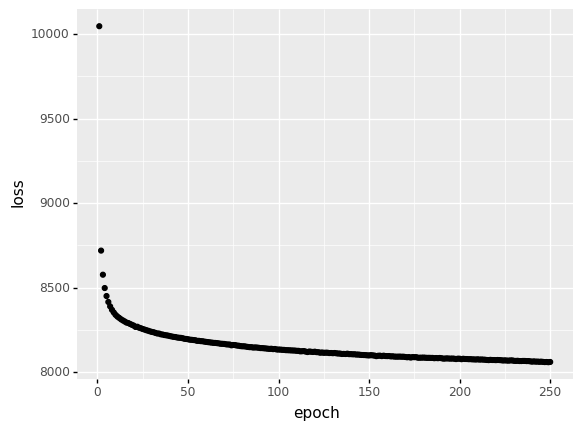

<ggplot: (102203876115)>

In [56]:
# see what information has been logged during the training process
simple_nn.history.history.keys()

# plot the training loss over epochs
loss_df = pd.DataFrame(simple_nn.history.history['loss'])
loss_df.columns = ['loss']
loss_df = loss_df.assign(epoch = np.arange(1, 251))

(
    ggplot(loss_df, aes(x='epoch', y='loss')) +
    geom_point()
)

We can see that the training loss is decreasing inverse logaritmic after each epoch.  
Potentially we could increase the amount of epochs to lower the loss further, however seeing the slope of the function we are close to plateuing.  
In order to avoid overfitting we choose not to increase the amount of epochs.

In [57]:
#Similar to the training set, however trying out less epochs with bigger batch size (22500 iterations)
simple_nn.fit(X_train, y_train, epochs=150, batch_size = 150, validation_data=(X_validation, y_validation))

Epoch 1/150
725/725 [==============================] - 1s 2ms/step - loss: 8054.1851 - val_loss: 9178.5967
Epoch 2/150
725/725 [==============================] - 1s 1ms/step - loss: 8055.8643 - val_loss: 9175.5020 ETA: 0s - loss: 8053.58
Epoch 3/150
725/725 [==============================] - 1s 1ms/step - loss: 8055.6772 - val_loss: 9178.4668oss: 7
Epoch 4/150
725/725 [==============================] - 1s 1ms/step - loss: 8055.6729 - val_loss: 9174.5742
Epoch 5/150
725/725 [==============================] - 1s 1ms/step - loss: 8055.6147 - val_loss: 9178.7695
Epoch 6/150
725/725 [==============================] - 1s 1ms/step - loss: 8055.0752 - val_loss: 9174.5977
Epoch 7/150
725/725 [==============================] - 1s 1ms/step - loss: 8055.3623 - val_loss: 9176.0537
Epoch 8/150
725/725 [==============================] - 1s 1ms/step - loss: 8053.9263 - val_loss: 9181.0010
Epoch 9/150
725/725 [==============================] - 1s 2ms/step - loss: 8054.5596 - val_loss: 9177.0283
Epoch 1

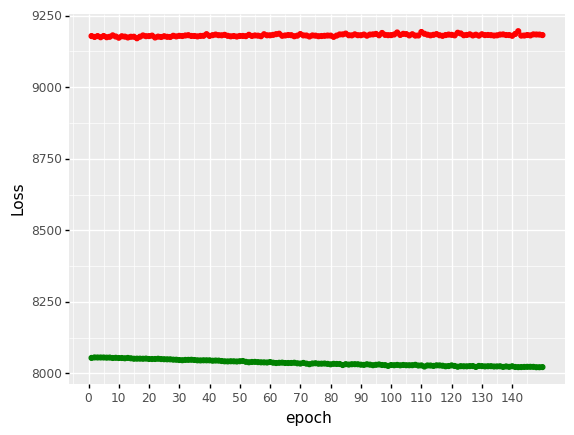

<ggplot: (102211985945)>

In [58]:
# plot the training loss over epochs
def plot_loss(nn_model):
    loss_df = pd.DataFrame({
        'train_loss': nn_model.history.history['loss'],
        'val_loss': nn_model.history.history['val_loss']
    })
    loss_df = loss_df.assign(epoch = np.arange(1, 151))

    p = (
        ggplot(loss_df) +
        geom_point(aes(x='epoch', y='train_loss'), color='green') +
        geom_point(aes(x='epoch', y='val_loss'), color='red') +
        scale_x_continuous(breaks = np.arange(0, 150, 10)) +
        ylab("Loss")
    )
    return p

plot_loss(simple_nn)

In [59]:
# saving the above simple nn fitted model using a keras save command

simple_nn.save('../dataset/simple_nn_model')

print("Storing the fitting history of simple nn to disk")
with open('../dataset/simple_nn_history.json', 'w') as handle:
    json.dump(simple_nn.history.history, handle)

INFO:tensorflow:Assets written to: ../dataset/simple_nn_model\assets
Storing the fitting history of simple nn to disk


In [60]:
# we can load the above save model like this:
simple_nn = keras.models.load_model("../dataset/simple_nn_model")
simple_nn

# reload the fitting history like this
with open("../dataset/simple_nn_history.json", "r") as handle:
    simple_nn_history = json.load(handle)

After we have determined at least the number of epochs that give us the best results on the validation dataset, we can train the model on the full train + validation set, and predict on the test set to get a final value for the model performance.

In [61]:
final_nn = Sequential()
final_nn.add(Dense(20, input_dim=X_train.shape[1], activation='relu'))
final_nn.add(Dense(1)) #, activation='sigmoid'
final_nn.compile(loss='mean_squared_error', optimizer='adam')
final_nn.fit(X_train_validation, y_train_validation, epochs=50, batch_size = 20, verbose=0)
y_hat_test_nn = final_nn.predict(X_test)
y_hat_test_nn = np.where(y_hat_test_nn >= 0.5, 1, 0)
print("The r2 score of the nn model is {}".format(r2_score(y_test, y_hat_test_nn)))

The r2 score of the nn model is -0.222260990967879


The R2 has dropped and became negative, we do not know how this has happened but most likely the NN couldn't find a proper way to acuratly predict the time to sell.

In [63]:
oversized_nn = Sequential()
oversized_nn.add(Dense(60, input_dim=X_train.shape[1], activation='relu'))
oversized_nn.add(Dense(40, activation='relu'))
oversized_nn.add(Dense(15, activation='relu'))
oversized_nn.add(Dense(1)) #, activation='sigmoid'
oversized_nn.compile(loss="mean_squared_error", optimizer="adam")
oversized_nn.fit(X_train, y_train, epochs=150, batch_size = 20, validation_data=(X_validation, y_validation))

Epoch 1/150
5431/5431 [==============================] - 9s 2ms/step - loss: 8592.4990 - val_loss: 9330.2109
Epoch 2/150
5431/5431 [==============================] - 8s 2ms/step - loss: 8348.2471 - val_loss: 9352.1611
Epoch 3/150
5431/5431 [==============================] - 8s 2ms/step - loss: 8282.0947 - val_loss: 9231.6592
Epoch 4/150
5431/5431 [==============================] - 8s 2ms/step - loss: 8241.3545 - val_loss: 9221.9844
Epoch 5/150
5431/5431 [==============================] - 8s 2ms/step - loss: 8212.0518 - val_loss: 9191.7725
Epoch 6/150
5431/5431 [==============================] - 8s 2ms/step - loss: 8189.2046 - val_loss: 9152.0508
Epoch 7/150
5431/5431 [==============================] - 8s 2ms/step - loss: 8146.9243 - val_loss: 9127.3799
Epoch 8/150
5431/5431 [==============================] - 8s 2ms/step - loss: 8120.3750 - val_loss: 9147.3379
Epoch 9/150
5431/5431 [==============================] - 8s 1ms/step - loss: 8091.1357 - val_loss: 9133.9277
Epoch 10/150
5431/5

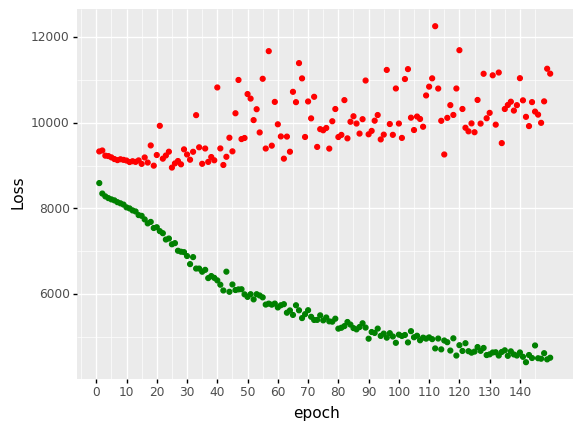

<ggplot: (102257453008)>

In [64]:
plot_loss(oversized_nn)

We can see that the neural network is only good at predicting the time to sell for the set it knows the values of.  
Once we introduce a new set of numbers, the loss function sporadically changes which explains the negative R2 value found.

## Hypertuning of neural network: batches, epochs, layers

There are many hyperparameters that can be tuned for neural networks: https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

Here we just show how we can tune batch size, number of epochs, and number of neurons in the hidden layers, with a simple grid search.

Note that in the above link, they use keras.wrappers.scikit_learn to turn a keras model into a sklearn model. However, this method is superseded by the scikeras package, which is the one we use below.
You can install this package by doing:

- pip instal scikeras

In [ ]:
#pip install scikeras

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# from keras.wrappers.scikit_learn import KerasClassifier
from scikeras.wrappers import KerasClassifier

In [ ]:
# function that creates the model
# note that we pass the number of neurons as a parameter to the network
def create_model(neurons=1):
    nn_model = Sequential()
    nn_model.add(Dense(neurons, input_dim=X_train.shape[1], activation="relu"))
    nn_model.add(Dense(1)) #, activation='sigmoid'
    nn_model.compile(loss='mean_squared_error', optimizer='adam')
    return nn_model

seed = 1234
np.random.seed(seed)

# turn the keras model into a sklearn compatible model
# note that the neurons parameter needs to be specified in the interface of KerasClassifier
model = KerasClassifier(build_fn=create_model, verbose=0, neurons=1)

In [ ]:
# define the grid search parameters
batch_size = [10, 20]
epochs = [100, 150]
neurons = [10, 20, 30]
params_grid = dict(batch_size=batch_size, epochs=epochs, neurons=neurons)

In [ ]:
params_grid

{'batch_size': [10, 20], 'epochs': [100, 150], 'neurons': [10, 20, 30]}

In [ ]:
#perform grid search with sklearn if needed, otherwise load the grid search already performed
if os.path.exists("../dataset/nn_grid_search.pickle") and USE_STORED_NN_HYPERTUNED_MODELS is True:
    with open('../dataset/nn_grid_search.pickle', 'rb') as handle:
        grid_search_nn = pickle.load(handle)
else:
    start_time = datetime.datetime.now()
    grid_search_nn = GridSearchCV(estimator=model, param_grid=params_grid, n_jobs=-1, cv=fold_index) #fold index is in svc hypertuning
    grid_search_nn = grid_search_nn.fit(X_train_validation, y_train_validation)
    end_time = datetime.datetime.now()
    print(f'hypertuning with sklearn grid search for neural networks complete in {round((end_time - start_time).seconds/60, 2)} minutes')
    # store the results of the grid search to disk
with open('../dataset/nn_grid_search.pickle', 'wb') as handle:
    pickle.dump(grid_search_nn, handle)

INFO:tensorflow:Assets written to: C:\Users\Eigenaar\AppData\Local\Temp\tmpcl0wup4n\assets


In [ ]:
grid_search_nn

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=KerasClassifier(build_fn=<function create_model at 0x000002566DF29280>, neurons=1, verbose=0),
             n_jobs=-1,
             param_grid={'batch_size': [10, 20], 'epochs': [100, 150],
                         'neurons': [10, 20, 30]})

In [ ]:
print("The best parameter combination is: {} with score: {}".format(grid_search_nn.best_params_, grid_search_nn.best_score_))

The best parameter combination is: {'batch_size': 10, 'epochs': 100, 'neurons': 10} with score: 0.004861111111111111


We now train a model with the best parameters found on train and validation, together:

In [ ]:
best_model = create_model(20)
best_model.fit(X_train_validation, y_train_validation, epochs=100, batch_size=10, verbose=0)

We can then evaluate the model so trained on the test set:

In [ ]:
y_hat_test = best_model.predict(X_test)
y_hat_test = np.where(y_hat_test >= 0.5, 1, 0)
r2_score(y_test, y_hat_test)

-0.22225967906137734